<a href="https://colab.research.google.com/github/snalluri12/backend/blob/main/hw3_LM_for_NLP_OMSCS_v1_part_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling

A language model attempts to approximate the underlying statistics of a text corpus $P(tok_n | tok_1, tok_2, ..., tok_{n-1}; \theta)$ where $\theta$ is a set of learned parameters/weights. For the purposes of this notebook, tokens will be words. Language models can be used for a variety of applications, one of which being text generation. In this assignement we will be looking at language modeling techniques of increasing sophistication.

**Tips:**
- Read all the code. We don't ask you to write the training loops, evaluation loops, and generation loops, but it is often instructive to see how the models are trained and evaluated.
- If you have a model that is learning (loss is decreasing), but you want to increase accuracy, try using ``nn.Dropout`` layers just before the final linear layer to force the model to handle missing or unfamiliar data.

In [164]:
# start time - notebook execution
import time
start_nb = time.time()

# Set up

Import packages

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
import unicodedata

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# Initialize the Autograder

In [166]:
# import the autograder tests
import hw3b_tests as ag

We will build a *vocabulary*, which will act as a dictionary of all the words our systems will know about. It will also allow us to map words to tokens, which will be unique indexes in the vocabulary. This will further allow us to transform words into one-hot vectors, where a word is represented as a vector of the same length as the vocabulary wherein all values are zeros except for the *i*th element, where *i* is the token number of the word.

In [167]:
class Vocab:
    def __init__(self, name):
        self.name = name                             # The name of the vocabulary
        self._word2index = {}                        # Map words to token index
        self._word2count = {}                        # Track how many times a word occurs in a corpus
        self._index2word = {0: "SOS", 1: "EOS"}      # Map token indexs back into words
        self._n_words = 2 # Count SOS and EOS        # Number of unique words in the corpus

    # Get a list of all words
    def get_words(self):
      return list(self._word2count.keys())

    # Get the number of words
    def num_words(self):
      return self._n_words

    # Convert a word into a token index
    def word2index(self, word):
      return self._word2index[word]

    # Convert a token into a word
    def index2word(self, word):
      return self._index2word[word]

    # Get the number of times a word occurs
    def word2count(self, word):
      return self._word2count[word]

    # Add all the words in a sentence to the vocabulary
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    # Add a single word to the vocabulary
    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

These are some helper functions to *normalize* texts, ie, make the text regular and remove some of the more problematic exceptions found in texts. This normalizer will make all words lowercase, trim plurals, and remove non-letter characters.

In [168]:
# Convert any unicode to ascii
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Download a corpus. This corpus is the ascii text of the book, *The Silmarillion*, by J.R.R. Tolkein. It has a lot of non-common words and names to illustrate how language models deal with such things.

In [169]:
# if data.txt is not in the current directory, download it
if not os.path.isfile('data.txt'):
  !wget -O data.txt https://www.dropbox.com/s/pgvn1n7t4sjxt8r/silmarillion?dl=1

Let's read in the data and take a look at it.

In [170]:
filename = 'data.txt'
with open(filename, encoding='utf-8') as f:
  text = f.read()
text[:1000]

'The Silmarillon Chapter 1\n\n\nOf the Beginning of Days It is told among the wise that the First War began before Arda was full-shaped, and ere yet there was any thing that grew or walked upon earth; and for long Melkor had the upper hand. But in the midst of the war a spirit of great strength and hardihood came to the aid of the Valar, hearing in the far heaven that there was battle in the Little Kingdom; and Arda was filled with the sound of his laughter. So came Tulkas the Strong, whose anger passes like a mighty wind, scattering cloud and darkness before it; and Melkor fled before his wrath and his laughter, and forsook Arda, and there was peace for a long age. And Tulkas remained and became one of the Valar of the Kingdom of Arda; but Melkor brooded in the outer darkness, and his hate was given to Tulkas for ever after.\n\nIn that time the Valar brought order to the seas and the lands and the mountains, and Yavanna planted at last the seeds that she had long devised. And since, w

Normalize the text and build the vocabulary

In [171]:
normalized_text = normalize_string(text)
VOCAB = Vocab("text")
VOCAB.add_sentence(normalized_text)

Make training and testing data splits.

In [172]:
# Convert every word into a token and build a numpy array of tokens
encoded_text = np.array([VOCAB.word2index(word) for word in normalized_text.split()])
print("The first 100 tokens")
print(encoded_text[:100])
# get the validation and the training data
test_split = 0.1
test_idx = int(len(encoded_text) * (1 - test_split))
TRAIN = encoded_text[:test_idx]
TEST = encoded_text[test_idx:]
# Decrease the size of the training set to make the assignment more tractable
TRAIN = TRAIN[:len(TRAIN)//10]

The first 100 tokens
[ 2  3  4  5  2  6  5  7  8  9 10 11  2 12 13  2 14 15 16 17 18 19 20 21
 22 23 24 25 19 26 27 13 28 29 30 31 32 22 33 34 35 36  2 37 38 39 40 41
  2 42  5  2 15 43 44  5 45 46 22 47 48 49  2 50  5  2 51 52 41  2 53 54
 13 25 19 55 41  2 56 57 22 18 19 58 59  2 60  5 61 62 39 63 48 64  2 65
 66 67 68 69]


# LSTM (20 Points)

A more sophisticated version of an RNN is a Long Short-Term Memory network (or an LSTM). It learns to decided what should be kept in the hidden state and what should be removed from the hidden state. This allows it to make better hidden states and thus learn a more accurate probability distribution and be a better generator.

We will make two LSTMs. First, we will make a neural network that uses Pytorch's built in `nn.LSTMCell`. The second time, we will write an LSTM memory cell from scratch.

**Complete the following network with two or more LSTMCell layers.** The network will take two inputs in its forward function:
- `x`: a sequence of words, represented as one-hots. The input should be a tensor of shape `1 x vocab_size` That is, each row is a one-hot (batch size is 1).
- `hc` which is a tuple containing (hidden_state, cell_state).

The output of the forward function will be:
- A sequence of output log probabilities. This output should be a tensor of shape `1 x vocab_size` where each row is a log probability distribution.
- A tuple containing (hidden_state, cell_state).

The network should contain two our more LSTMCell modules. Send the one-hot into the first LSTMCell along with the original `hc`. Then send the resulting hidden state to the next higher LSTMCell *along with the initial `hc`*. Keep doing this until you get to the top of the stack of LSTMCells. Once you get to the top of the stack, use an affine transformation to expand to vocabular size and generate a log probability with a log softmax.

Forward should return the output log probabilities and a (hidden state, cell state) tuple.

In [173]:
# build the model using the pytorch nn module
class MyLSTM(nn.ModuleList):
  def __init__(self, input_size, hidden_size, cell_type = nn.LSTMCell):
    super(MyLSTM, self).__init__()

    # init the parameters
    self.hidden_dim = hidden_size
    self.input_size = input_size

    ### Use the cell_type passed into the constructor as the type of LSTM cell module
    ### that is made. For the first part of the assignment, this will be the
    ### default nn.LSTMCell. For the second part, this will be the custom-written
    ### LSTM cell type.

    ### BEGIN SOLUTION
    self.cell1 = cell_type(input_size, hidden_size)
    self.cell2 = cell_type(hidden_size, hidden_size)
    self.output = nn.Linear(hidden_size, input_size)
    ### END SOLUTION

  def forward(self, x, hc):
    # Return values
    output = None
    hidden = None
    cell = None

    # Pass the hidden and the cell state from one lstm cell to the next one
    # we also feed the output of the first layer lstm cell at time step t to the second layer cell
    # init both layer cells with the zero hidden and zero cell states

    ### BEGIN SOLUTION
    # first LSTM cell
    hidden_init, cell_init = hc
    #print(hidden_state.shape)
    hidden0, cell0 = self.cell1(x, (hidden_init, cell_init))
    # second LSTM cell: resulting hidden state from cell 0
    hidden, cell = self.cell2(hidden0, (hidden_init, cell_init))
    linear = self.output(hidden)
    output = F.log_softmax(linear, dim=1)

    ### END SOLUTION

    return output, (hidden.detach(), cell.detach())

  def init_hidden(self):
    # initialize the hidden state and the cell state to zeros
    return (torch.zeros(1, self.hidden_dim), # 1 is the batch size
            torch.zeros(1, self.hidden_dim)) # 1 is the batch size


Let's build our LSTM

In [174]:
# It's ok to change this cell, however, you should not need to change it much (if at all) - note: certain changes may break the autograder, e.g.,
# increasing the size of the hidden layer could cause out of memory errors in the autograder and large numbers of epochs could cause autograder to time
# out (pay attention to the runtime of your notebook and the warnings that are printed out at the end of the notebook)
LSTM_HIDDEN_SIZE = 50
LSTM_NUM_EPOCHS = 4
LSTM_LEARNING_RATE = 0.01

In [175]:
lstm = MyLSTM(VOCAB.num_words(), LSTM_HIDDEN_SIZE)
optimizer_lstm = optim.SGD(lstm.parameters(), lr=LSTM_LEARNING_RATE)
criterion_lstm = nn.NLLLoss()

In [176]:
# student check - the following test must return a value of 3 to receive credit (5 pts)
ag.LSTM_check()

Number of layers found, 5, is correct.
Test A: 5/5


In [177]:
# student check - the following test must return a value of 5 to receive credit (5 pts)
ag.unit_test_LSTM_structure()

torch.Size([1, 100]) torch.Size([1, 50]) torch.Size([1, 50])
NllLossBackward0
LogSoftmaxBackward0
AddmmBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TBackwa

## LSTM---Training

Here is the training loop. Notice it uses `get_rnn_x_y()` from HW2.


In [178]:
def train_lstm(net, optimizer, criterion, num_epochs, data):
  epoch_losses = []
  scheduler = ExponentialLR(optimizer, gamma=0.9)
  net.train()
  for epoch in range(num_epochs):
    losses = []
    hc = net.init_hidden()
    for i in range(len(data)-1):
      x, y = ag.get_rnn_x_y(data, i, VOCAB.num_words())
      x = x.float()
      output, hc = net(x, hc)
      loss = criterion(output, y)
      losses.append(loss.detach())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if i%1000 == 0:
        print('iter', i, 'loss', torch.stack(losses).mean().item())
    scheduler.step()
    print('epoch', epoch, 'loss', torch.stack(losses).mean().item())
    epoch_losses.append(torch.stack(losses).mean().item())
  return epoch_losses

In [179]:
epoch_losses = train_lstm(lstm, optimizer_lstm, criterion_lstm, num_epochs=LSTM_NUM_EPOCHS, data=TRAIN)

iter 0 loss 8.799407958984375
iter 1000 loss 8.512471199035645
iter 2000 loss 8.286568641662598
iter 3000 loss 7.8360466957092285
iter 4000 loss 7.592194557189941
iter 5000 loss 7.4146809577941895
iter 6000 loss 7.261857986450195
iter 7000 loss 7.132044792175293
iter 8000 loss 7.022651195526123
iter 9000 loss 6.912978172302246
iter 10000 loss 6.836582660675049
iter 11000 loss 6.76475715637207
epoch 0 loss 6.72762393951416
iter 0 loss 8.673189163208008
iter 1000 loss 6.022003173828125
iter 2000 loss 6.026082992553711
iter 3000 loss 5.968142986297607
iter 4000 loss 5.9905805587768555
iter 5000 loss 6.0090155601501465
iter 6000 loss 6.013297080993652
iter 7000 loss 6.010043621063232
iter 8000 loss 6.002552509307861
iter 9000 loss 5.979328632354736
iter 10000 loss 5.9698920249938965
iter 11000 loss 5.954415321350098
epoch 1 loss 5.944079875946045
iter 0 loss 8.585311889648438
iter 1000 loss 5.879137992858887
iter 2000 loss 5.8915581703186035
iter 3000 loss 5.843772888183594
iter 4000 loss 

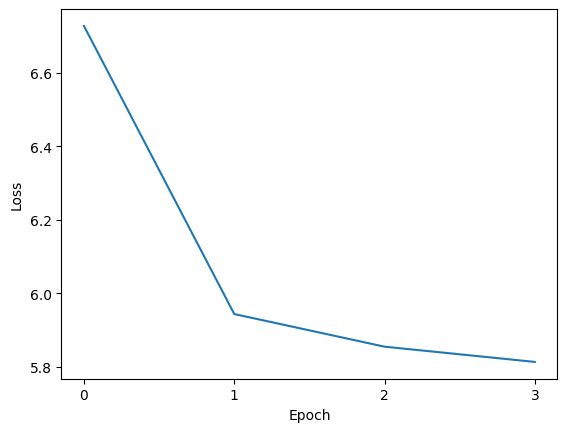

In [180]:
plt.figure(1)
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(epoch_losses)))
plt.plot(epoch_losses)

You should see a curve that slopes down steeply at first and then levels out to some asymptotic minimum.

## LSTM---Testing

Evaluation works the same as with the RNN.

In [181]:
# student check - the following test must return a value less than 1000 to receive credit (10 pts)
ag.eval_lstm_1(max_perplexity=1000)

491.7368469238281
Perplexity is less than 1000
Test C: 10/10


## LSTM---Generation

Generation works the same as the RNN. In fact you will notice that we can use the `prep_hidden_state` and `generate_rnn` functions without modification.

In [182]:
# It's ok to change this cell
LSTM_TEMPERATURE = 0.5

In [183]:
# COPY YOUR HW3-A SOLUTION HERE
def token2onehot(token, vocab_size = VOCAB.num_words()):
  one_hot = None
  ### BEGIN SOLUTION
  one_hot = torch.zeros(1,vocab_size)
  # assign 1
  one_hot[0][token] = 1
  ### END SOLUTION
  return one_hot

# COPIED FROM HW3-A
def prep_hidden_state(tokenized_input, rnn, verbose=False):
  # Get an initial hidden state
  hidden_state = rnn.init_hidden()
  # Run the input prompt through the RNN to build up the hidden state.
  # Discard the outputs (we are not trying to make predictions) until we get to the end
  for token in tokenized_input:
    if verbose:
      print("current token:", token, VOCAB.index2word(token))
    # Get the one-hot for the current token
    x = token2onehot(token)
    x = x.float()
    # Run the current one-hot and hidden state through the RNN
    output, hidden_state = rnn(x, hidden_state)
    # Get the highest predicted token
    next_token = output.argmax().item()
    if verbose:
      print("predicted next token:", next_token, VOCAB.index2word(next_token), '\n')
  return hidden_state

# COPY YOUR HW3-A SOLUTION HERE
def my_temperature_sample(log_probs, temperature=1.0):
  token = None
  ### BEGIN SOLUTION
  # normal probabilities
  adjusted_prob = torch.exp(log_probs/temperature)
  token = torch.multinomial(adjusted_prob, 1)
  #print(token)
  token = token.item()
  ### END SOLUTION
  return token

# COPIED FROM HW3-A
def generate_rnn(rnn, num_new_tokens, token, hidden_state, fn=lambda d:d.argmax().item(), verbose=False):
  # Keep generating more by feeding the predicted output back into the RNN as input
  # Start with the last token of the input prompt and the newly prepped hidden state
  if verbose:
    print("Generating continuation:\n")
  continuation = []
  for n in range(num_new_tokens):
    if verbose:
      print("current token:", token, VOCAB.index2word(token))
    # Get the one-hot for the current token
    x = token2onehot(token)
    x = x.float()
    # Run the current one-hot through the RNN
    output, hidden_state = rnn(x, hidden_state)
    # Predict the next token
    next_token = fn(output)
    if verbose:
      print("predicted next token:", next_token, VOCAB.index2word(next_token), '\n')
    # Remember the new token
    continuation.append(next_token)
    # update the current
    token = next_token
  return continuation

# Example input prompt:
input_prompt = "the First War began"
# How long should the continuation be?
num_new_tokens = 10

# Normalize the input
normalized_input = normalize_string(input_prompt)
# Tokenize the input
tokenized_input = [VOCAB.word2index(w) for w in normalized_input.split()]
print("input prompt:", input_prompt)
print("input tokens:", tokenized_input, '\n')

# Get the hidden state that represents the input prompt
print("Prepping hidden state:\n")
hidden_state = prep_hidden_state(tokenized_input, lstm, verbose=True)

# Generate the continuation. Use the argmax function to sample from the RNN's outputs
token = tokenized_input[-1]
continuation = generate_rnn(lstm, num_new_tokens, token, hidden_state, fn=lambda d:my_temperature_sample(d, LSTM_TEMPERATURE), verbose=True)

# All done
print("Final continuation:")
print(continuation)
continuation_text = [VOCAB.index2word(t) for t in continuation]
print(continuation_text)
print("Final:")
print(input_prompt + ' ' + ' '.join(continuation_text))

input prompt: the First War began
input tokens: [2, 14, 15, 16] 

Prepping hidden state:

current token: 2 the
predicted next token: 2 the 

current token: 14 first
predicted next token: 2 the 

current token: 15 war
predicted next token: 2 the 

current token: 16 began
predicted next token: 2 the 

Generating continuation:

current token: 16 began
predicted next token: 22 and 

current token: 22 and
predicted next token: 2 the 

current token: 2 the
predicted next token: 22 and 

current token: 22 and
predicted next token: 2 the 

current token: 2 the
predicted next token: 39 . 

current token: 39 .
predicted next token: 129 them 

current token: 129 them
predicted next token: 2 the 

current token: 2 the
predicted next token: 22 and 

current token: 22 and
predicted next token: 41 in 

current token: 41 in
predicted next token: 120 which 

Final continuation:
[22, 2, 22, 2, 39, 129, 2, 22, 41, 120]
['and', 'the', 'and', 'the', '.', 'them', 'the', 'and', 'in', 'which']
Final:
the Firs

# LSTM From Scratch (40 Points)

Now we do LSTM the hard way---creating the LSTM cells by hand.

**Complete the following functions inside the `MyLSTMCell` class.**

We have broken the forward function into multiple parts:
- Forget gate: determine what of the previous cell state should be discarded (by multiplying 0 or 1 produced by a sigmoid against the cell state).  `forget_gate()` implements $f=\sigma(W_{i,f}x+b_{i,f} + W_{h,f}h+b_{h,f})$.
- Input gate: determine what of the input should be introduced to the cell memory. `input_gate()` implements $i=\sigma(W_{i,i}x+b_{i,i}+W_{h,i}h+b_{h,i})$
- Cell memory: update the previous cell memory state to make a new cell memory state. `cell_memory()` implements $c'=f*c + i*tanh(W_{i,g}x+b_{i,g} + W_{h,g}h + b_{h,g})$.
- Output gate: determine what from the current cell memory state. `output_gate()` implements $o=\sigma(W_{i,o}x+b_{i,o}+W_{h,o}h+b_{h,o})$.
- A final function `hidden_out()` will produce the new hidden state by implementing $h'=o*tanh(c')$.

You will also need to initialize any linear layer modules, activation functions, etc. in the constructor.

In [184]:
class MyLSTMCell(torch.nn.Module):

  def __init__(self, input_size=10, hidden_size=64):
    super(MyLSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    ### BEGIN SOLUTION
    # forget gate
    self.linear_fh = nn.Linear(hidden_size, hidden_size)
    self.linear_fi = nn.Linear(input_size, hidden_size)
    # g
    self.linear_gh = nn.Linear(hidden_size, hidden_size)
    self.linear_gi = nn.Linear(input_size, hidden_size)
    # input gate
    self.linear_ih = nn.Linear(hidden_size, hidden_size)
    self.linear_ii = nn.Linear(input_size, hidden_size)
    # output gate
    self.linear_oh = nn.Linear(hidden_size, hidden_size)
    self.linear_oi = nn.Linear(input_size, hidden_size)
    ### END SOLUTION

  ### The Forget Gate takes in the input (x) and hidden state (h)
  ### The input and hidden state pass through their own linear compression layers,
  ### then are concatenated and passed through a sigmoid
  def forget_gate(self, x, h):
    f = None # The gate vector to return
    ### BEGIN SOLUTION
    # sigmoid activation
    linear_h = self.linear_fh(h)
    linear_i = self.linear_fi(x)
    f = torch.sigmoid(linear_h + linear_i)
    ### END SOLUTION
    return f

  ### The Input Gate takes the input (x) and hidden state (h)
  ### The input and hidden state pass through their own linear compression layers,
  ### then are concatenated and passed through a sigmoid
  def input_gate(self, x, h):
    i = None # The gate vector to return
    ### BEGIN SOLUTION
    linear_h = self.linear_ih(h)
    linear_i = self.linear_ii(x)
    i = torch.sigmoid(linear_h + linear_i)
    ### END SOLUTION
    return i

  ### The Cell memory gate takes the results from the input gate (i), the results from the forget gate (f)
  ### the original input (x), the hidden state(h) and the previous cell state (c_prev).
  ### 1. The Cell memory gate compresses the input and hidden and concatenates them and passes it through a Tanh.
  ### 2. The resultant intermediate tensor is multiplied by the results from the input gate to determine
  ###    what new information is allowed to carry on
  ### 3. The results from the forget state are multiplied against the previous cell state (c_prev) to determine
  ###    what should be removed from the cell state.
  ### 4. The new cell state (c_next) is the new information that survived the input gate and the previous
  ###    cell state that survived the forget gate.
  ### The new cell state c_next is returned
  def cell_memory(self, i, f, x, h, c_prev):
    c_next = None
    ### BEGIN SOLUTION
    linear_h = self.linear_gh(h)
    linear_i = self.linear_gi(x)
    intermediate = torch.tanh(linear_h + linear_i)
    input_tan = i * intermediate
    forget_prev = f * c_prev
    c_next = input_tan + forget_prev
    #print(c_next)
    ### END SOLUTION
    return c_next

  ### The Out gate takes the original input (x) and the hidden state (h)
  ### The gate passes the input and hidden through their own compression layers and
  ### then concatenates to send through a sigmoid
  def out_gate(self, x, h):
    o = None # The gate vector to return
    ### BEGIN SOLUTION
    linear_h = self.linear_oh(h)
    linear_i = self.linear_oi(x)
    o = torch.sigmoid(linear_h + linear_i)
    ### END SOLUTION
    return o

  ### This function assembles the new hidden state, give the results of the output gate (o)
  ### and the new cells sate (c_next).
  ### This function runs c_next through a tanh to get a 1 or -1 which will flip some of the
  ### elements of the output.
  def hidden_out(self, o, c_next):
    h_next = None
    ### BEGIN SOLUTION
    h_next = torch.tanh(c_next) * o
    ### END SOLUTION
    return h_next

  def forward(self, x, hc):
    (h, c_prev) = hc
    # Equation 1. input gate
    i = self.input_gate(x, h)

    # Equation 2. forget gate
    f = self.forget_gate(x, h)

    # Equation 3. updating the cell memory
    c_next = self.cell_memory(i, f, x, h, c_prev)

    # Equation 4. calculate the main output gate
    o = self.out_gate(x, h)

    # Equation 5. produce next hidden output
    h_next = self.hidden_out(o, c_next)

    return h_next, c_next

  def init_hidden(self):
    return (torch.zeros(1, self.hidden_size),
            torch.zeros(1, self.hidden_size))

In [185]:
# student check - the following test must return a value of 6 to receive credit (5 pts)
ag.test_myLSTMCell_structure(MyLSTMCell)

torch.Size([1, 50]) torch.Size([1, 50])
NllLossBackward0
MulBackward0
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
NllLossBackward0
MulBackward0
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
Ac

In [186]:
# student check - the following test must return a value of 8 to receive credit (5 pts)
ag.MyLSTMCell_linear_layer_size_check()

Number of linear layers found, 8, is correct.
Test E: 5/5.0


Let's build a cell. A cell doesn't do much by itself.

In [187]:
cell = MyLSTMCell(input_size=VOCAB.num_words(), hidden_size=64)

In [188]:
# student check - the following test must return a value of 22 to receive credit (10 pts)
ag.test_gate_structure(cell)

SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SigmoidBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
Sigmoi

Now let's load your `MyLSTMCell` class into `MyLSTM`.

In [189]:
# It's ok to change this cell, however, you should not need to change it much (if at all) - note: certain changes may break the autograder, e.g.,
# increasing the size of the hidden layer could cause out of memory errors in the autograder and large numbers of epochs could cause autograder to time
# out (pay attention to the runtime of your notebook and the warnings that are printed out at the end of the notebook)
MY_CELL_HIDDEN_SIZE = 64
MY_CELL_NUM_EPOCHS = 3
MY_CELL_LEARNING_RATE = 0.01

In [190]:
my_cell_lstm = MyLSTM(input_size=VOCAB.num_words(), hidden_size=MY_CELL_HIDDEN_SIZE, cell_type=MyLSTMCell)
optimizer_my_cell = optim.SGD(my_cell_lstm.parameters(), lr=MY_CELL_LEARNING_RATE)
criterion_my_cell = nn.NLLLoss()

## LSTM From Scratch---Training

Lets see if your combination of `MyLSTM` using `MyLSTMCell` learns. We don't need to update the training loop

In [191]:
epoch_losses = train_lstm(my_cell_lstm, optimizer_my_cell, criterion_my_cell, num_epochs=MY_CELL_NUM_EPOCHS, data=TRAIN)

iter 0 loss 8.633623123168945
iter 1000 loss 8.51939582824707
iter 2000 loss 8.331156730651855
iter 3000 loss 7.916265964508057
iter 4000 loss 7.672266960144043
iter 5000 loss 7.4915971755981445
iter 6000 loss 7.329868316650391
iter 7000 loss 7.19071102142334
iter 8000 loss 7.073894023895264
iter 9000 loss 6.957127094268799
iter 10000 loss 6.873840808868408
iter 11000 loss 6.798099517822266
epoch 0 loss 6.758619785308838
iter 0 loss 8.489060401916504
iter 1000 loss 6.012884140014648
iter 2000 loss 6.021740436553955
iter 3000 loss 5.9658002853393555
iter 4000 loss 5.989513397216797
iter 5000 loss 6.009385585784912
iter 6000 loss 6.012665748596191
iter 7000 loss 6.009995937347412
iter 8000 loss 6.002444267272949
iter 9000 loss 5.977999210357666
iter 10000 loss 5.967276573181152
iter 11000 loss 5.951794147491455
epoch 1 loss 5.9412946701049805
iter 0 loss 8.424174308776855
iter 1000 loss 5.868842601776123
iter 2000 loss 5.883376598358154
iter 3000 loss 5.838275909423828
iter 4000 loss 5.8

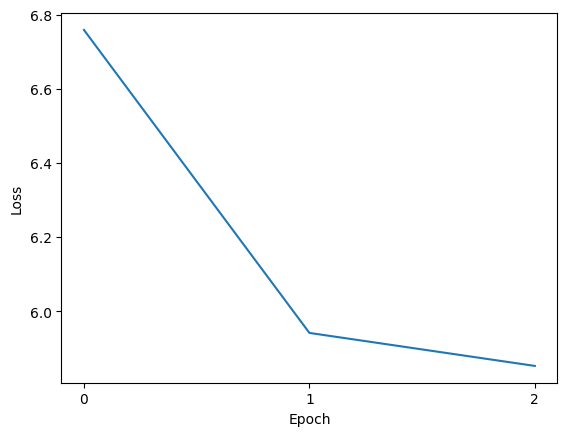

In [192]:
plt.figure(1)
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(epoch_losses)))
plt.plot(epoch_losses)

You should see a curve that slopes down steeply at first and then levels out to some asymptotic minimum.

## LSTM From Scratch---Testing

We don't need to update the evaluation loop

In [193]:
# student check - the following test must return a value less than 1000 to receive credit (20 pts)
ag.eval_lstm_2(max_perplexity=1000)

495.984375
Perplexity is less than 1000
Test G: 20/20


## LSTM From Scratch---Generation

Generation works the same.

In [194]:
# It's ok to change this cell
MY_CELL_TEMPERATURE = 0.5

In [195]:
# Example input prompt:
input_prompt = "the First War began"
# How long should the continuation be?
num_new_tokens = 10

# Normalize the input
normalized_input = normalize_string(input_prompt)
# Tokenize the input
tokenized_input = [VOCAB.word2index(w) for w in normalized_input.split()]
print("input prompt:", input_prompt)
print("input tokens:", tokenized_input, '\n')

# Get the hidden state that represents the input prompt
print("Prepping hidden state:\n")
hidden_state = prep_hidden_state(tokenized_input, my_cell_lstm, verbose=True)

# Generate the continuation. Use the argmax function to sample from the RNN's outputs
token = tokenized_input[-1]
continuation = generate_rnn(my_cell_lstm, num_new_tokens, token, hidden_state, fn=lambda d:my_temperature_sample(d, MY_CELL_TEMPERATURE), verbose=True)

# All done
print("Final continuation:")
print(continuation)
continuation_text = [VOCAB.index2word(t) for t in continuation]
print(continuation_text)
print("Final:")
print(input_prompt + ' ' + ' '.join(continuation_text))

input prompt: the First War began
input tokens: [2, 14, 15, 16] 

Prepping hidden state:

current token: 2 the
predicted next token: 2 the 

current token: 14 first
predicted next token: 2 the 

current token: 15 war
predicted next token: 2 the 

current token: 16 began
predicted next token: 2 the 

Generating continuation:

current token: 16 began
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 5 of 

current token: 5 of
predicted next token: 2 the 

current token: 2 the
predicted next token: 2 the 

current token: 2 the
predicted next token: 49 to 

Final continuation:
[2, 2, 2, 2, 2, 2, 5, 2, 2, 49]
['the', 'the', 'the', 'the', 'the', 'the', 'of', 'the', 'the', 'to']
Final:
the First War began the the the th

# Attention (40 Points)

Attention allows the network to look back at previous data when trying to predict the next token.

We will split the LSTM into an Encoder and a Decoder. The Encoder's job will be to update the hidden state based on the latest token. The Decoder's job is to predict the next token (log softmax over the vocabulary) based on the current hidden state as well as *n* previous hidden states. You will see that the training loop now collects up a stack of hidden states to pass to the Decoder. The Decoder will figure out how much the network should attend to each of the *n* prior hidden states before making its final prediction.

The Encoder will be a simple `nn.LSTMCell`. While the encoder could be more complicated, this allows us to focus on the Decoder. The Decoder is more complicated, involving both an LSTMCell and an attention mechanism.

**Complete the class defnition below**

`MyAttentionDecoder` will implement another `nn.LSTMCell` plus an attention mechanism.

Inputs:
- `x`: a one-hot of the current token as a `1 x vocab_size` tensor
- `hc`: a tuple containing a tuple with encoder's hidden state and memory cell state. The hidden state and cell state are both `1 x hidden_size` tensors.
- `encoder_outputs`: a history of *n* encoded hidden states, as a `n x hidden_size` tensor (this data is not batched).

Outputs:
- `h_hat`: a log softmax probability distribution over the vocabular, as a `1 x vocab_size` tensor
- `hc_out`: a tuple containing the LSTMCell's hidden state and memory cell state. The hidden state and cell state are both `1 x hidden_size` tensors.

In [196]:
class MyAttentionDecoder(nn.Module):
  def __init__(self, hidden_size, input_size, max_length):
    super(MyAttentionDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.max_length = max_length
    ### BEGIN SOLUTION
    self.input_compression = nn.Linear(input_size, hidden_size)
    # hidden*2, max_len_seq
    self.attention = nn.Linear(hidden_size * 2, max_length)
    # Combine input and hs to hidden size
    self.attention_combine = nn.Linear(2 * hidden_size, hidden_size)

    # lstm
    self.lstm_cell = nn.LSTMCell(hidden_size, hidden_size)
    # final output
    self.output = nn.Linear(hidden_size, input_size)

    # need to have total of 8 linear layers
    self.linear5 = nn.Linear(max_length, 1)
    self.linear6 = nn.Linear(max_length, 1)
    self.linear7 = nn.Linear(max_length, 1)
    self.linear8 = nn.Linear(max_length, 1)


    ### END SOLUTION

  def forward(self, x, hc, encoder_outputs):
    n = encoder_outputs.size(0)
    # citation for squeezing/unsqueezing: https://docs.pytorch.org/docs/stable/generated/torch.unsqueeze.html
    # apply previous hidden state to encoder outputs
    # citation (begin): https://docs.pytorch.org/docs/stable/generated/torch.Tensor.expand.html
    hs_expanded = hc[0].expand(n, -1)
    # citation (end): https://docs.pytorch.org/docs/stable/generated/torch.Tensor.expand.html
    # concatenate hidden state (t-1) + encoder outputs
    attention_input = torch.cat((encoder_outputs, hs_expanded), dim=1)
    # apply linear layer to get scores
    attention_scores = self.attention(attention_input)
    #print(attention_scores)
    #print(attention_scores.shape)
    # only want 1 score per time step
    attention_scores = attention_scores.mean(dim=1, keepdim=True)
    #print(attention_scores)
    #print(attention_scores.shape)
    # softmax to transposed scores
    attention_weights = F.softmax(attention_scores.t(), dim=1)
    # need to turn into 3D tensors for bmm
    attention_weights = attention_weights.unsqueeze(1)
    encoder_outputs = encoder_outputs.unsqueeze(0)
    # matrix multiplication
    new_hs = torch.bmm(attention_weights, encoder_outputs).squeeze(1)

    # compress x to hidden size
    x_proj = self.input_compression(x)
    # Combine input and context
    x_combined = torch.cat((x_proj, new_hs), dim=1)
    x_combined_trans = self.attention_combine(x_combined)
    # Apply nonlinearity (4 relu layers)
    nl_combined = F.relu(x_combined_trans)
    nl_combined = F.relu(nl_combined)
    nl_combined = F.relu(nl_combined)
    nl_combined = F.relu(nl_combined)

    # run through ltsm cell
    h_new, c_new = self.lstm_cell(nl_combined, (hc[0], hc[1]))
    output = self.output(h_new)
    log_probs = F.log_softmax(output, dim=1)
    hc_out = (h_new, c_new)
    ### END SOLUTION
    return log_probs, hc_out

  def init_hidden(self):
    return (torch.zeros(1, self.hidden_size),
            torch.zeros(1, self.hidden_size))

In [197]:
# It's ok to change this cell, however, you should not need to change it much (if at all) - note: certain changes may break the autograder, e.g.,
# increasing the size of the hidden layer could cause out of memory errors in the autograder and large numbers of epochs could cause autograder to time
# out (pay attention to the runtime of your notebook and the warnings that are printed out at the end of the notebook)
ATTN_MAX_LENGTH = 5  # The number of past hidden states that can be attended to
ATTN_HIDDEN_SIZE = 60
ATTN_NUM_EPOCHS = 3
ATTN_LEARNING_RATE = 0.01

In [198]:
attn_encoder = nn.LSTMCell(VOCAB.num_words(), ATTN_HIDDEN_SIZE)
attn_decoder = MyAttentionDecoder(ATTN_HIDDEN_SIZE, VOCAB.num_words(), ATTN_MAX_LENGTH)
attn_criterion = nn.NLLLoss()
attn_encoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=ATTN_LEARNING_RATE, momentum=0.9)
attn_decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=ATTN_LEARNING_RATE, momentum=0.9)

In [199]:
# student check - the following test must return a value of 4 to receive credit (10 pts)
ag.test_attention_structure()

torch.Size([1, 100]) torch.Size([1, 64]) torch.Size([1, 64])
--
NllLossBackward0
LogSoftmaxBackward0
AddmmBackward0
AccumulateGrad
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
ReluBackward0
ReluBackward0
ReluBackward0
ReluBackward0
AddmmBackward0
AccumulateGrad
CatBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SqueezeBackward1
BmmBackward0
UnsqueezeBackward0
SoftmaxBackward0
TBackward0
MeanBackward1
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TBackward0
AccumulateGrad
TanhBackward0
AddBackward0
MulBackward0
SigmoidBackward0
UnsafeSplitBackward0
AddBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
AddmmBackward0
AccumulateGrad
ReluBackward0
ReluBackward0
ReluBackward0
ReluBackward0
AddmmBackward0
AccumulateGrad
CatBackward0
AddmmBackward0
AccumulateGrad
TBackward0
AccumulateGrad
SqueezeBackward1
BmmBackward0
Uns

In [200]:
# student check - the following test must return a value of 8 to receive credit (10 pts)
ag.attention_linear_layer_size_check()

Number of linear layers found, 4, is correct.
Test I: 10/10


## Attention---Training

The training loop is a bit more involved because it must collect up a number of past hidden states. It still uses your `get_rnn_x_y()` function though.

In [201]:
def train_attn(data, num_epochs, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=ATTN_MAX_LENGTH):
  epoch_losses = []
  encoder.train()
  decoder.train()
  for epoch in range(num_epochs):
    losses = []
    # Get an empty hc
    encoder_hc = decoder.init_hidden()
    # Create an empty history of hiddens
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    for iter in range(len(data)-1):
      x, y = ag.get_rnn_x_y(data, iter, VOCAB.num_words())
      x = x.float()
      # Call encoder
      encoder_hidden, encoder_cell = encoder(x, encoder_hc)
      encoder_hc = (encoder_hidden, encoder_cell)
      # unbatch the hidden so it can be added to encoder_outputs
      encoder_output = encoder_hidden[0]
      # Shift all the previous outputs
      # Grab elements 1...max (dropping row 0) and flatten
      encoder_outputs = encoder_outputs[1:,:].view(-1)
      # Add the new output
      encoder_outputs = torch.cat((encoder_outputs, encoder_output.detach()))
      # re-fold
      encoder_outputs = encoder_outputs.view(max_length, -1)
      # decoder's input hc is the encoder's output hc
      decoder_hc = encoder_hc
      # Call the decoder
      decoder_output, decoder_hc = decoder(x, decoder_hc, encoder_outputs)

      loss = criterion(decoder_output, y)
      losses.append(loss)

      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()
      loss.backward()
      encoder_optimizer.step()
      decoder_optimizer.step()

      # Prep the decoder hc for the next iteration
      encoder_hc = (decoder_hc[0].detach(), decoder_hc[1].detach())

      if iter%1000 == 0:
        print("iter", iter, "loss", torch.stack(losses).mean().item())
    print("epoch", epoch, "loss", torch.stack(losses).mean().item())
    epoch_losses.append(torch.stack(losses).mean().item())
  return epoch_losses

In [202]:
epoch_losses = train_attn(TRAIN, ATTN_NUM_EPOCHS, attn_encoder, attn_decoder, attn_encoder_optimizer, attn_decoder_optimizer, attn_criterion, ATTN_MAX_LENGTH)

iter 0 loss 8.580536842346191
iter 1000 loss 6.805522441864014
iter 2000 loss 6.538802146911621
iter 3000 loss 6.353196620941162
iter 4000 loss 6.296921730041504
iter 5000 loss 6.251097202301025
iter 6000 loss 6.207496643066406
iter 7000 loss 6.16765832901001
iter 8000 loss 6.117837429046631
iter 9000 loss 6.051389694213867
iter 10000 loss 6.015615463256836
iter 11000 loss 5.970926761627197
epoch 0 loss 5.943697452545166
iter 0 loss 6.251501083374023
iter 1000 loss 5.465932369232178
iter 2000 loss 5.498825550079346
iter 3000 loss 5.442476272583008
iter 4000 loss 5.468780517578125
iter 5000 loss 5.480052471160889
iter 6000 loss 5.48099422454834
iter 7000 loss 5.4813618659973145
iter 8000 loss 5.465270042419434
iter 9000 loss 5.424196720123291
iter 10000 loss 5.409275054931641
iter 11000 loss 5.384425163269043
epoch 1 loss 5.366455554962158
iter 0 loss 5.806661605834961
iter 1000 loss 5.191471576690674
iter 2000 loss 5.249866008758545
iter 3000 loss 5.216944694519043
iter 4000 loss 5.242

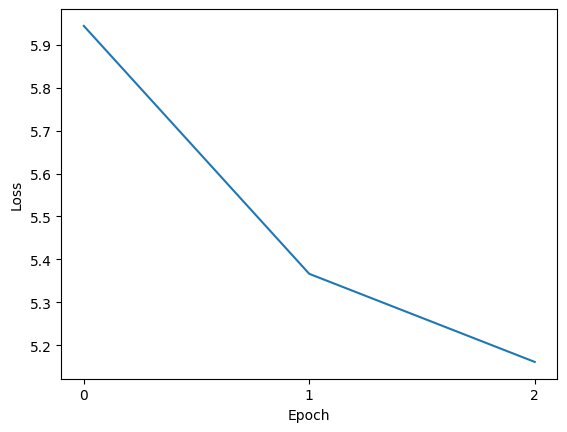

In [203]:
plt.figure(1)
plt.clf()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(epoch_losses)))
plt.plot(epoch_losses)

You should see a curve that slopes down steeply at first and then levels out to some asymptotic minimum.

## Attention---Testing

In [204]:
# student check - the following test must return a value less than 1000 to receive credit (20 pts)
ag.eval_attn(max_perplexity=1000)

Perplexity = 387.465087890625
Perplexity is less than 1000
Test J: 20/20


# Grading

Please submit this .ipynb file to Gradescope for grading.

## Final Grade

In [205]:
# student check
ag.final_grade()

Your projected points for this assignment is 380/100.

NOTE: THIS IS NOT YOUR FINAL GRADE. YOUR FINAL GRADE FOR THIS ASSIGNMENT WILL BE AT LEAST 380 OR MORE, BUT NOT LESS



## Notebook Runtime

In [206]:
# end time - notebook execution
end_nb = time.time()
# print notebook execution time in minutes
print("Notebook execution time in minutes =", (end_nb - start_nb)/60)
# warn student if notebook execution time is greater than 30 minutes
if (end_nb - start_nb)/60 > 30:
  print("WARNING: Notebook execution time is greater than 30 minutes. Your submission may not complete auto-grading on Gradescope. Please optimize your code to reduce the notebook execution time.")

Notebook execution time in minutes = 15.626330395539602
